In [1]:
%load_ext autoreload
%autoreload 2

from utilities.evaluator import Evaluator
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def ket_bra(v1,v2):
    """
    Assuming v has shape (1,d)
    """
    return np.dot(v1.T,v2)

def bra_ket(v1,v2):
    """
    Assuming v has shape (1,d)
    """
    return np.dot(v1,v2.T)

def proj(v):
    if len(v.shape) < 2:
        v = np.expand_dims(v,axis=0)
    P= ket_bra(v,v)
    return P

def normalize(a):
    return np.array(a)/np.sqrt(np.sum(np.square(a)))

In [3]:
b2 = [np.expand_dims(np.eye(2)[k],axis=0) for k in range(2)]
bas = [ket_bra(b2[i], b2[j]) for i in range(2) for j in range(2)]

In [4]:
def give_choi(gamma):
    
    K0 = np.array([[1,0], [0, np.sqrt(1-gamma)]])
    K1 = np.array([[0, np.sqrt(gamma)], [0,0]])
    krauss = [K0, K1]
    
    choi = np.zeros((4,4))
    for kk in range(len(bas)):
        state = bas[kk]
        action_state = np.zeros(state.shape)
        for k in krauss:
            action_state += np.dot(np.dot(k, state), k.T)
        prod = np.kron(action_state, state)
        choi += prod
    return choi

In [5]:
def psuc_ea(chois):
    F_0, F_1  = cp.Variable((4,4)), cp.Variable((4,4))
    sig = cp.Variable((2,2), hermitian=True)
    constraints = [sig>>0, cp.trace(sig)==1, F_0 >>0, F_1 >> 0,  (F_0 + F_1) == cp.kron(np.eye(2),sig)]
    objective = cp.Minimize(1- (0.5*(cp.trace( chois[0] @ F_0) + cp.trace(chois[1] @ F_1))))
    prob = cp.Problem(objective, constraints)
    cost = prob.solve(solver="MOSEK")
    return cost

In [7]:
chois = [give_choi(g) for g in [.01, 1]]
psuc_ea(chois)

0.004987558602109199

In [10]:
rr=[]

values_gamma0 = np.linspace(0,1,100)
for p in tqdm(values_gamma0):
    chois = [give_choi(g) for g in [p, 1]]
    rr.append(psuc_ea(chois))


100%|██████████| 100/100 [00:04<00:00, 24.02it/s]


In [11]:
evaluator = Evaluator({"n_qubits":2,"env_mode":1, "problem_name":"QADC", "params":[0.01,1]})

gamma_mancini = np.linspace(0,np.pi/2,100)
gg = [evaluator.pmancini_Eq15(np.arcsin(np.sqrt(p)),np.pi/2) for p in values_gamma0]
ggEA = [evaluator.pmancini_Eq18(np.arcsin(np.sqrt(p)), np.pi/2) for p in values_gamma0]

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

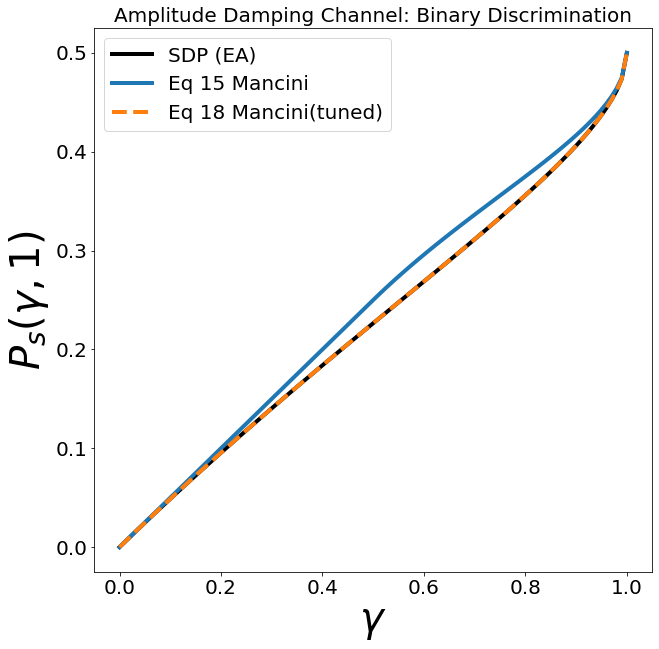

In [35]:
plt.figure(figsize=(10,10))
plt.plot(values_gamma0,rr, color="black", linewidth=4, label="SDP (EA)")
plt.plot(values_gamma0, gg, linewidth=4,label="Eq 15 Mancini")
plt.plot(values_gamma0, 0.5*(1+np.array(ggEA)/2), '--', linewidth=4, label="Eq 18 Mancini(tuned)")
plt.xlabel(r'$\gamma$', size=40)
plt.ylabel(r'$P_s(\gamma, 1)$',size=40)
plt.legend(prop={"size":20})
plt.title("Amplitude Damping Channel: Binary Discrimination", size=20)
plt.xticks(size=20)
plt.yticks(size=20)